In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model
from train_test import evaluate_model_sr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Data Pre-processing

In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_HR

<xarray.Dataset> Size: 342GB
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [4]:
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR

<xarray.Dataset> Size: 171GB
Dimensions:       (time: 731, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

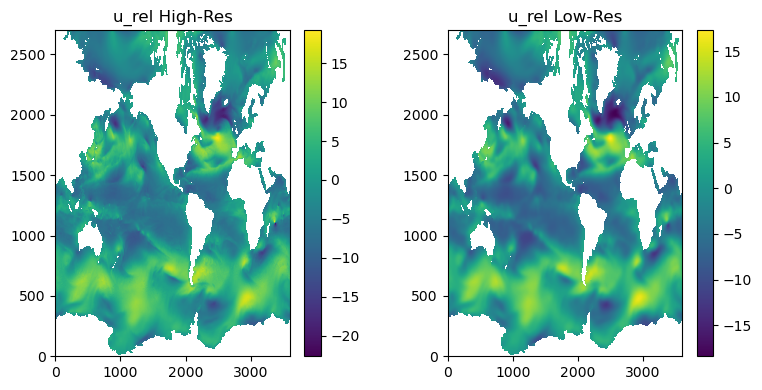

In [38]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_HR.u_relative.isel(time=0))
axes[0].set_title("u_rel High-Res")
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_LR.u_relative.isel(time=0))
axes[1].set_title("u_rel Low-Res")
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()


In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [10]:
# Check if NaNs are present
#ds_HR_pac = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
#data = ds_HR_pac.u_relative.isel(time=0)

#nan_present = data.isnull().any().compute().item()
#print("Contains NaNs:", nan_present)

In [11]:
# If NaNs are present, replace w/ zeros
#ds_LR_pac = ds_LR_pac.fillna(0)
#ds_HR_pac = ds_HR_pac.fillna(0)

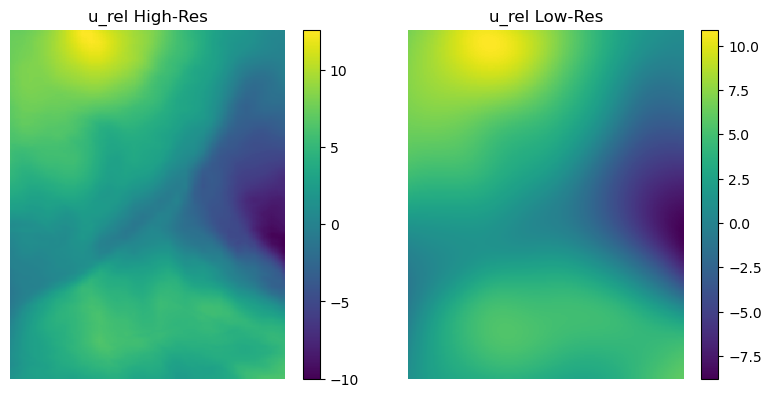

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_HR_reg.u_relative.isel(time=0))
axes[0].set_title("u_rel High-Res")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_LR_reg.u_relative.isel(time=0))
axes[1].set_title("u_rel Low-Res")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
# Total number of samples
n_samples = len(ds_HR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = ds_HR_reg.isel(time=train_indices)
val_data_HR = ds_HR_reg.isel(time=val_indices)
test_data_HR = ds_HR_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


In [7]:
# Extract HR data
urel_HR_train = train_data_HR.u_relative.values ## training
urel_HR_val = val_data_HR.u_relative.values ## validation
urel_HR_test = test_data_HR.u_relative ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_relative.values ## training
urel_LR_val = val_data_LR.u_relative.values ## validation
urel_LR_test = test_data_LR.u_relative.values ## testing

# Case 1: Special Super-res Evaluation Function -- Combined Loss

## Training U-Net

In [8]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [9]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case1.pth',
            n_epochs=100) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 3.238e+01, Val Loss: 3.765e+01, Epoch Time: 146.05s
Model saved at epoch 1
Epoch 2, Train Loss: 2.661e+01, Val Loss: 2.862e+01, Epoch Time: 143.49s
Model saved at epoch 2
Epoch 3, Train Loss: 2.394e+01, Val Loss: 2.309e+01, Epoch Time: 143.58s
Model saved at epoch 3
Epoch 4, Train Loss: 2.169e+01, Val Loss: 2.216e+01, Epoch Time: 143.53s
Model saved at epoch 4
Epoch 5, Train Loss: 1.966e+01, Val Loss: 2.007e+01, Epoch Time: 142.76s
Model saved at epoch 5
Epoch 6, Train Loss: 1.766e+01, Val Loss: 1.871e+01, Epoch Time: 146.20s
Model saved at epoch 6
Epoch 7, Train Loss: 1.590e+01, Val Loss: 1.537e+01, Epoch Time: 153.65s
Model saved at epoch 7
Epoch 8, Train Loss: 1.433e+01, Val Loss: 1.344e+01, Epoch Time: 145.24s
Model saved at epoch 8
Epoch 9, Train Loss: 1.267e+01, Val Loss: 1.118e+01, Epoch Time: 144.87s
Model saved at epoch 9
Epoch 10, Train Loss: 1.121e+01, Val Loss: 1.217e+01, Epoch Time: 144.68s
Model saved at epoch 10
Epoch 11

In [12]:
sr_pred = evaluate_model_sr(model, device, test_loader, urel_HR_test, './model_case1.pth')
sr_pred

Loaded model parameters from ./model_case1.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ -4.4801517 ,  -5.8232164 ,  -5.795803  , ...,  -4.779155  ,
          -4.7327085 ,  -3.995538  ],
        [ -5.4648943 ,  -5.871002  ,  -5.688429  , ...,  -4.66202   ,
          -4.8017874 ,  -4.47663   ],
        [ -5.746071  ,  -5.8755455 ,  -5.7500167 , ...,  -4.6050153 ,
          -4.6775265 ,  -4.842698  ],
        ...,
        [ -7.7159853 ,  -7.9204893 ,  -7.608905  , ...,  -3.6172264 ,
          -3.559855  ,  -3.6413136 ],
        [ -7.151814  ,  -7.6339135 ,  -7.7721176 , ...,  -3.3158362 ,
          -3.4539666 ,  -3.257381  ],
        [ -5.7160473 ,  -6.9419475 ,  -7.4690704 , ...,  -3.397822  ,
          -3.2666812 ,  -2.550977  ]],

       [[ -7.3833766 ,  -9.813693  ,  -9.766293  , ...,  -4.752868  ,
          -4.6252356 ,  -3.871125  ],
        [ -9.130582  , -10.09399   ,  -9.653855  , ...,  -4.597405  ,
          -4.644632  ,  -4.3459682 ],
        [ -9.568892  , -10.0997925 ,  -9.749664  , ...,  -4.492448  ,
          -4.5042696 ,  -4.6509047 ],
...
          -5.1261396 ,  -5.39612   ],
        [ -2.9522576 ,  -3.0267568 ,  -3.284522  , ...,  -4.861477  ,
          -5.188408  ,  -5.0531974 ],
        [ -2.429087  ,  -2.9282963 ,  -3.206896  , ...,  -5.1331925 ,
          -4.966159  ,  -4.057477  ]],

       [[ -4.9039025 ,  -6.4224124 ,  -6.406608  , ...,  -9.370056  ,
          -8.966739  ,  -7.74302   ],
        [ -5.9677315 ,  -6.464121  ,  -6.2645392 , ...,  -9.326784  ,
          -9.400967  ,  -8.8547735 ],
        [ -6.2018604 ,  -6.404169  ,  -6.2727966 , ...,  -9.105028  ,
          -9.16737   ,  -9.396347  ],
        ...,
        [  1.0005572 ,   0.9336317 ,   0.8322211 , ...,   6.5375357 ,
           6.796961  ,   6.39521   ],
        [  0.47880656,   0.78052795,   0.67233866, ...,   6.664581  ,
           6.8584404 ,   6.3729486 ],
        [  0.3811527 ,   0.6293918 ,   0.37558872, ...,   6.4769936 ,
           6.7043977 ,   5.417938  ]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0196-08-10 12:00:00 ... 0190-07-23 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

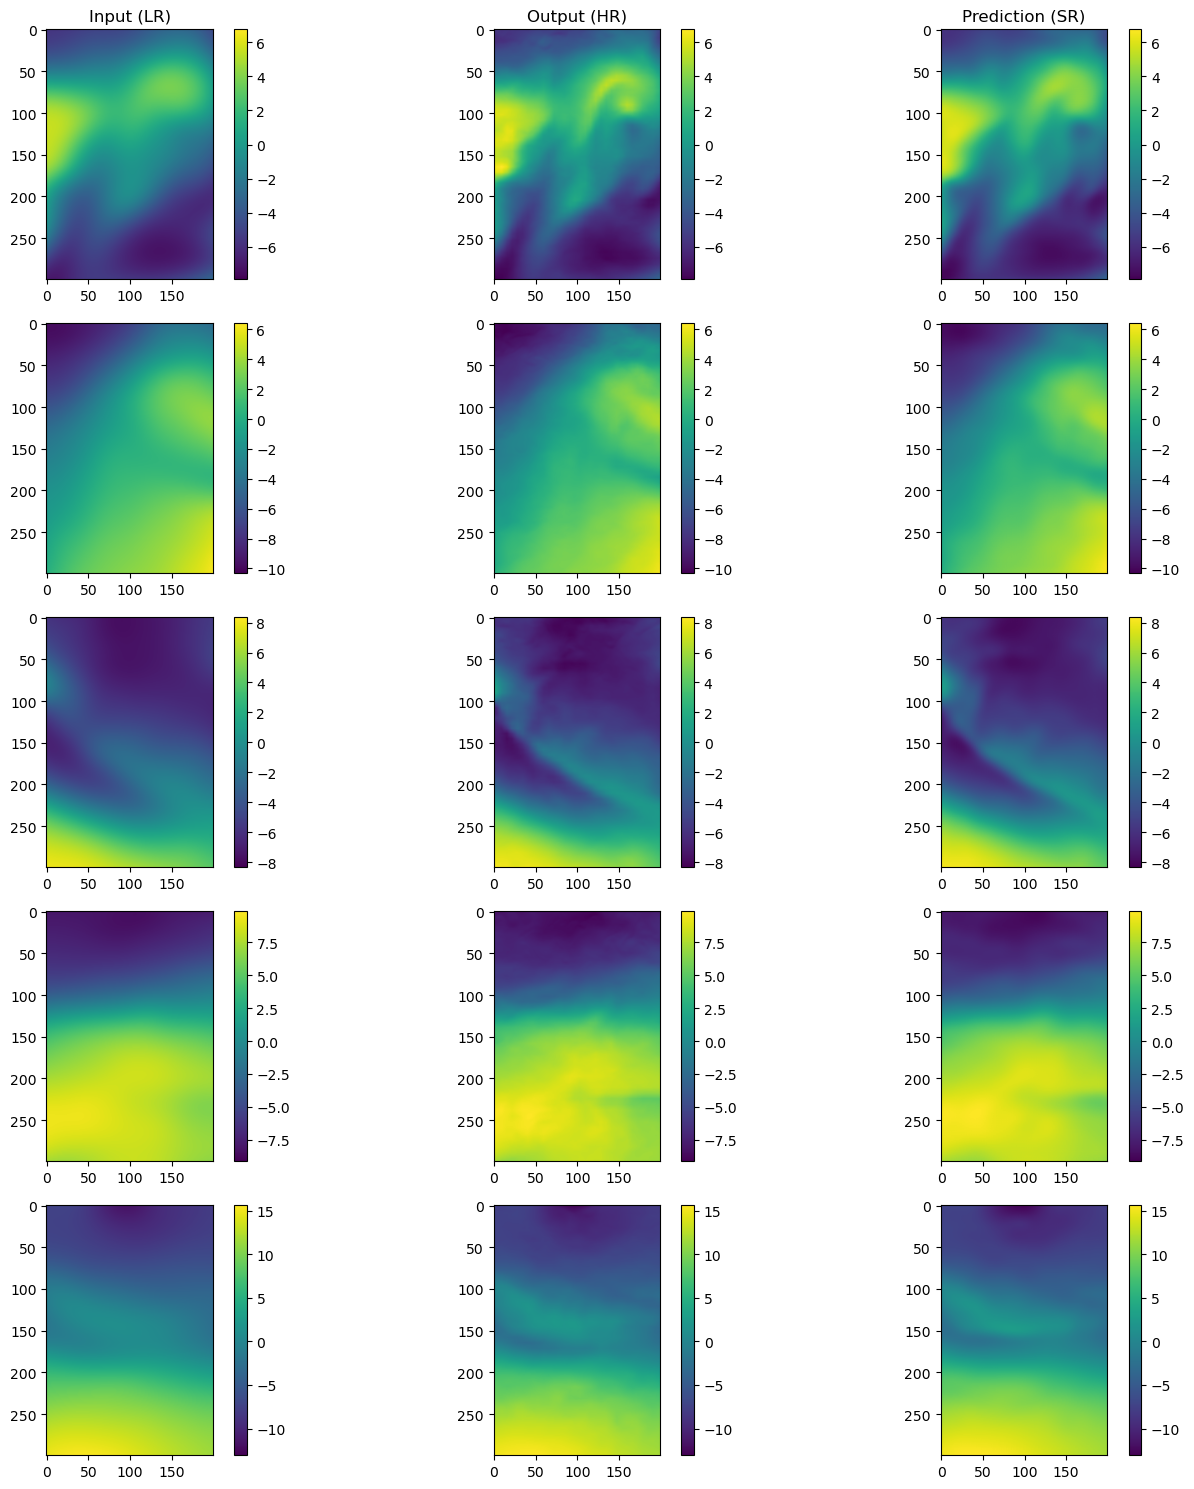

In [13]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

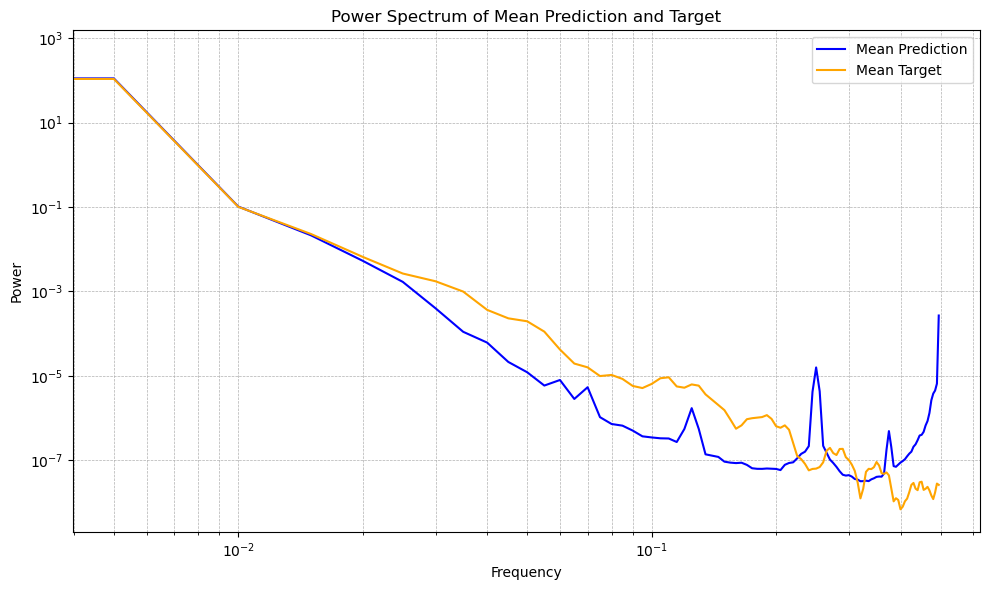

In [15]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(sr_pred.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = sr_pred.mean(dim='time')  # Squeeze to remove the channel dimension and compute mean
mean_target = urel_HR_test.mean(dim='time')

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction, dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target, dims=dims, coords=coords)

mean_prediction_da = mean_prediction_da.chunk({'xt_ocean': -1})  # one chunk along xt_ocean
mean_target_da = mean_target_da.chunk({'xt_ocean': -1})

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


# Error Analysis

In [27]:
prediction_da = sr_pred
prediction_da

<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ -4.4801517 ,  -5.8232164 ,  -5.795803  , ...,  -4.779155  ,
          -4.7327085 ,  -3.995538  ],
        [ -5.4648943 ,  -5.871002  ,  -5.688429  , ...,  -4.66202   ,
          -4.8017874 ,  -4.47663   ],
        [ -5.746071  ,  -5.8755455 ,  -5.7500167 , ...,  -4.6050153 ,
          -4.6775265 ,  -4.842698  ],
        ...,
        [ -7.7159853 ,  -7.9204893 ,  -7.608905  , ...,  -3.6172264 ,
          -3.559855  ,  -3.6413136 ],
        [ -7.151814  ,  -7.6339135 ,  -7.7721176 , ...,  -3.3158362 ,
          -3.4539666 ,  -3.257381  ],
        [ -5.7160473 ,  -6.9419475 ,  -7.4690704 , ...,  -3.397822  ,
          -3.2666812 ,  -2.550977  ]],

       [[ -7.3833766 ,  -9.813693  ,  -9.766293  , ...,  -4.752868  ,
          -4.6252356 ,  -3.871125  ],
        [ -9.130582  , -10.09399   ,  -9.653855  , ...,  -4.597405  ,
          -4.644632  ,  -4.3459682 ],
        [ -9.568892  , -10.0997925 ,  -9.749664  , ...,  -4.492448  ,
          -4.5042696 ,  -4.6509047 ],
...
          -5.1261396 ,  -5.39612   ],
        [ -2.9522576 ,  -3.0267568 ,  -3.284522  , ...,  -4.861477  ,
          -5.188408  ,  -5.0531974 ],
        [ -2.429087  ,  -2.9282963 ,  -3.206896  , ...,  -5.1331925 ,
          -4.966159  ,  -4.057477  ]],

       [[ -4.9039025 ,  -6.4224124 ,  -6.406608  , ...,  -9.370056  ,
          -8.966739  ,  -7.74302   ],
        [ -5.9677315 ,  -6.464121  ,  -6.2645392 , ...,  -9.326784  ,
          -9.400967  ,  -8.8547735 ],
        [ -6.2018604 ,  -6.404169  ,  -6.2727966 , ...,  -9.105028  ,
          -9.16737   ,  -9.396347  ],
        ...,
        [  1.0005572 ,   0.9336317 ,   0.8322211 , ...,   6.5375357 ,
           6.796961  ,   6.39521   ],
        [  0.47880656,   0.78052795,   0.67233866, ...,   6.664581  ,
           6.8584404 ,   6.3729486 ],
        [  0.3811527 ,   0.6293918 ,   0.37558872, ...,   6.4769936 ,
           6.7043977 ,   5.417938  ]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0196-08-10 12:00:00 ... 0190-07-23 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [47]:
target_da = urel_HR_test
target_da

<xarray.DataArray 'u_relative' (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
dask.array<getitem, shape=(111, 300, 200), dtype=float32, chunksize=(1, 300, 200), chunktype=numpy.ndarray>
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 480kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 240kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 480kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 480kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 240kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 240kB dask.array<chunksize=(300, 200), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 240kB dask.array<chunksize=(300, 200), meta=np.ndarray>
  * time      (time) object 888B 0196-08-10 12:00:00 ... 0190-07-23 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1
    wet       (yt_ocean, xt_ocean) float64 480kB dask.array<chunksize=(300, 200), meta=np.ndarray>

In [49]:
def r2_score(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - ss_res / ss_total

def r_corr(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    vx = y_true - y_true_mean
    vy = y_pred - y_pred_mean
    return np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

In [50]:
r2 = r2_score(target_da, prediction_da)
r2

np.float32(0.99898607)

In [51]:
corr = r_corr(target_da, prediction_da)
corr

np.float32(0.999563)

In [52]:
# Per pixel mean absolute error (MAE) statistics

# y_true and y_pred are numpy arrays of shape (N, H, W)
# N: number of samples, H: height, W: width

# 1. Compute absolute errors (N, H, W)
abs_errors = np.abs(target_da - prediction_da)

# 2. For each pixel (h,w), get distribution over N samples
# Example stats:

# Mean absolute error per pixel: shape (H, W)
mae_per_pixel = np.mean(abs_errors, axis=0)

# Median absolute error per pixel
median_ae_per_pixel = np.median(abs_errors, axis=0)

# Std deviation of absolute error per pixel
std_ae_per_pixel = np.std(abs_errors, axis=0)

In [55]:
flat_mae = mae_per_pixel.values.flatten()

summary = {
    'Mean MAE': np.mean(flat_mae),
    'Median MAE': np.median(flat_mae),
    'Std MAE': np.std(flat_mae),
    'Min MAE': np.min(flat_mae),
    'Max MAE': np.max(flat_mae),
    '25th Percentile': np.percentile(flat_mae, 25),
    '75th Percentile': np.percentile(flat_mae, 75)
}

summary

{'Mean MAE': np.float32(0.14821015),
 'Median MAE': np.float32(0.14603871),
 'Std MAE': np.float32(0.02052361),
 'Min MAE': np.float32(0.09313186),
 'Max MAE': np.float32(1.3046741),
 '25th Percentile': np.float32(0.13575576),
 '75th Percentile': np.float32(0.15779214)}